In [1]:
import pandas as pd, numpy as np
import seaborn as sns, matplotlib.pyplot as plt
import datetime
import os, sys, yaml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

notebook_dir = os.path.dirname(os.path.abspath('__file__'))
project_root = os.path.abspath(os.path.join(notebook_dir, os.pardir))

if project_root not in sys.path:
    sys.path.append(project_root)

with open('../config/params_tcm2013.yaml', 'r') as f:
    config_params = yaml.safe_load(f)

# Helper functions

# Convert time values in seconds to a readable format.
readable_time = lambda seconds: np.nan if pd.isna(seconds) else str(datetime.timedelta(seconds=int(seconds)))

# The inverse operation. Convert time from a string in the 'hh:mm:ss' to total seconds.
def time_to_seconds(time_str):
    time = datetime.datetime.strptime(time_str,"%H:%M:%S")
    return datetime.timedelta(hours=time.hour, minutes=time.minute, seconds=time.second).total_seconds()

# Put the time values (in seconds) of the x-axis labels of a coordinate system ax to a readable format.
def format_xticks_labels(ax, xlabel='Final time'):
    x_tick_locs = ax.get_xticks()
    x_tick_labels = [readable_time(tick) for tick in x_tick_locs]    
    ax.set_xticks(x_tick_locs)
    ax.set_xticklabels(x_tick_labels, rotation=60)
    ax.set_xlabel(xlabel)

# Put the time values (in seconds) of the y-axis labels of a coordinate system ax to a readable format.
def format_yticks_labels(ax, ylabel='Final time'):
    y_tick_locs = ax.get_yticks()
    y_tick_labels = [readable_time(tick) for tick in y_tick_locs]    
    ax.set_yticks(y_tick_locs)
    ax.set_yticklabels(y_tick_labels)
    ax.set_ylabel(ylabel)

RUNNER_ID = config_params['scraping']['runner_id']
SPLITS_DISTANCE = config_params['splits']['distance']
SPLIT_INFO = config_params['cleaning']['split_info']
SPLITS_CHIPSTART = config_params['splits']['start']['ChipStart']

output_file_clean = os.path.join(project_root, config_params['cleaning']['output_file'])
df = pd.read_csv(output_file_clean, index_col=RUNNER_ID)
df.head()

,age,sex,residence,split_1_segment_time,split_1_overall_place,split_1_pace,split_2_segment_time,split_2_overall_place,split_2_pace,split_3_segment_time,...,split_5_segment_time,split_5_overall_place,split_5_pace,split_6_segment_time,split_6_overall_place,split_6_pace,split_7_segment_time,split_7_overall_place,split_7_pace,chipstart
runner_id,,,,,,,,,,,,,,,,,,,,,
1,28.0,M,CA,961.0,3.0,310.0,953.0,7.0,307.0,2104.0,...,718.0,5.0,305.0,936.0,2.0,312.0,667.0,3.0,304.0,1
2,26.0,M,MA,963.0,12.0,310.0,967.0,15.0,311.0,2127.0,...,710.0,2.0,301.0,942.0,5.0,314.0,686.0,8.0,312.0,1
4,29.0,M,CA,961.0,6.0,310.0,952.0,1.0,307.0,2093.0,...,717.0,4.0,304.0,936.0,3.0,312.0,656.0,2.0,298.0,1
5,30.0,M,AZ,961.0,5.0,310.0,954.0,10.0,307.0,2104.0,...,719.0,6.0,305.0,935.0,1.0,312.0,653.0,1.0,297.0,0
6,27.0,M,MI,962.0,9.0,310.0,954.0,8.0,307.0,2107.0,...,707.0,1.0,300.0,964.0,8.0,322.0,718.0,15.0,327.0,0


In [2]:
# The column names are customizable. Cf. config/params.yaml .
segment_time_columns = [f'split_{i}_segment_time' for i, split in enumerate(SPLITS_DISTANCE, start=1)]
segment_pace_columns = [f'split_{i}_pace' for i, split in enumerate(SPLITS_DISTANCE, start=1)]

missing_splits = df[segment_time_columns].isna().any(axis=1)
df_missing = df[missing_splits].copy()
df = df[~missing_splits].copy()

df['final'] = df[segment_time_columns].sum(axis=1)

Let us build a polynomial regression for the final time based on the 5K, 10K, 13.1M (half-marathon) and 30K split times.

In [6]:
segments_to_consider = [1, 2, 3]
segment_columns_to_consider = [f'split_{i}_segment_time' for i in segments_to_consider]

X = df[segment_columns_to_consider]
y = df['final']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.5)

degree = 2 # Let's try a quadratic one.
model = make_pipeline(PolynomialFeatures(degree=degree), LinearRegression())

model.fit(X_train, y_train)

y_val_pred = model.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
readable_time(val_rmse)

'0:11:55'

Given that the mean final time is about 4 hours 17 minutes (see `02-data_analysis-tcm2013`), a degree-3 polynomial regression provides a pretty decent finishing time predictor. Let us add age and sex to the set of features to consider.

In [7]:
numerical = segment_columns_to_consider + ['age']
categorical = ['sex']

X = df[numerical + categorical]
y = df['final']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.5)

preprocess = ColumnTransformer(transformers=[('num', StandardScaler(), numerical),
                                             ('cat', OneHotEncoder(), categorical)])

model = Pipeline(steps=[('preprocessor', preprocess), 
                        ('poly_features', PolynomialFeatures(degree=2)),
                        ('regression', LinearRegression())])

model.fit(X_train, y_train)

y_val_pred = model.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
readable_time(val_rmse)

'0:11:39'

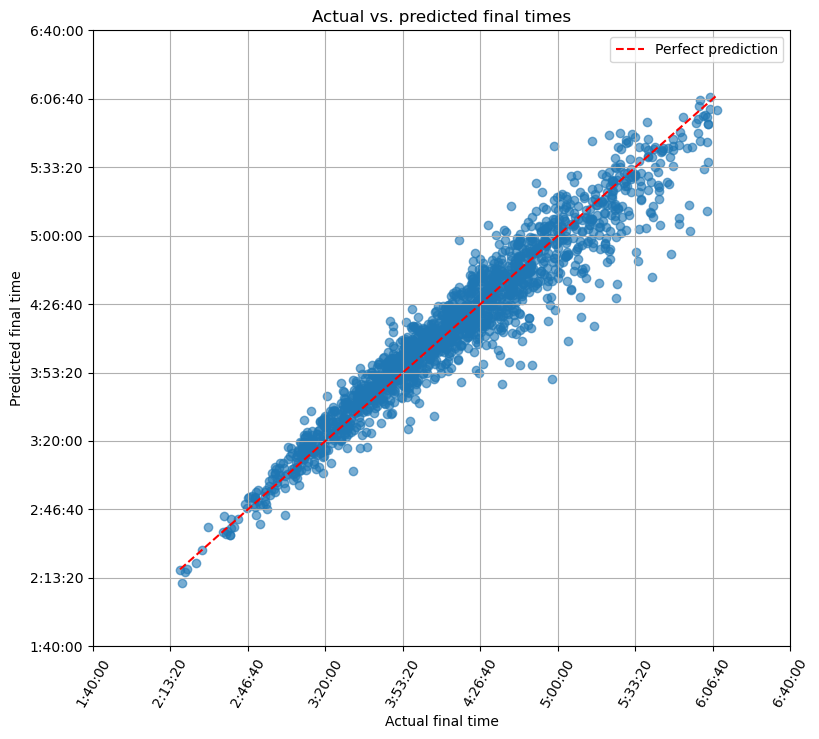

In [9]:
y_test_pred = model.predict(X_test)

plt.figure(figsize=(9, 8))
ax = plt.gca()
plt.scatter(y_test, y_test_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], 
         [y_test.min(), y_test.max()], 'r--', label='Perfect prediction')
plt.title('Actual vs. predicted final times')

format_xticks_labels(ax, 'Actual final time')
format_yticks_labels(ax, 'Predicted final time')

plt.legend()
plt.grid(True)
plt.show()